# Machine Learning Project
## Spring 2020
#### 20110236 Ahmed Anwar
#### 19030012 Mahrukh Zubair

### 0. Load Dependencies

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from gensim.models import KeyedVectors
from tqdm.notebook import tqdm
import time

## 1. Data Preprocessing

### 1.1 Parse Data

In [0]:
train_df = pd.read_csv('train.txt', sep=",", header=None, names=["isSarcasm", "headline"])
test_df  = pd.read_csv('test.txt' , sep=",", header=None, names=["isSarcasm", "headline"])

In [0]:
stopwords = []
file = open("stopwords.txt", "r")
for word in file:
    stopwords.append(word.rstrip())

### 1.2 Data Cleaning
1. Convert all to lowercase
2. Remove Punctuations
3. Remove numbers from text
4. Remove Stopwords

In [0]:
def clean(df):
    df['headline'] = df['headline'].str.lower()
    df['headline'] = pd.Series([x.translate(str.maketrans('', '', string.punctuation)) for x in df['headline']]) 
    df['headline'] = df['headline'].str.replace(r'[0-9]+', '')
    df['headline'] = df['headline'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)])) 
    return df

In [0]:
train_df_clean = clean(train_df)
test_df_clean  = clean(test_df)

In [0]:
train_df_clean.head()

,isSarcasm,headline
0,1,paramount executive snaps script begins studio...
1,1,increasingly paranoid campbells begins stockpi...
2,1,monster truck escapes
3,0,sunday roundup
4,1,birthday card david axelrod circling around af...


### 1.3 Load Pre-trained Word2Vec Model

In [0]:
model = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True) 

In [0]:
model_vocab = list(model.vocab.keys())

In [0]:
print('Vocabulary Length:',len(model_vocab))

Vocabulary Length: 3000000


### 1.4 Retrieve Features and Labels

In [0]:
def get_features_and_labels(df):
    
    n = len(df['headline'])
    features = np.zeros(shape=(n,300,))
    labels = np.array(df['isSarcasm']).reshape(n,1)
    
    for i in tqdm(range(n)):
        headline = df['headline'][i]
        words = headline.split()
        counter = 0

        for word in words: 
            try:
                features[i,:] = features[i,:] + model[word]
                counter+=1
            except:
                pass
            
        if counter != 0:
            features[i,:]/=counter 
            
    return features, labels

In [0]:
X_train, y_train = get_features_and_labels(train_df_clean)
X_test,  y_test  = get_features_and_labels(test_df_clean)

In [0]:
print('Training examples :', len(X_train))
print('Testing examples  :', len(X_test))

Training examples : 22047
Testing examples  : 5724


### 1.5 Save Features

In [0]:
np.save('X_train',X_train)
np.save('X_test',X_test)

np.save('y_train',y_train)
np.save('y_test',y_test)

In [0]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

### 1.6 Define Evaluation function

In [0]:
def model_evaluation(y_pred,y_true,model='normal'):
    
    if model == 'perceptron':
        m = -1
    else:
        m = 0
        
    TP  = ((y_pred==1) & (y_true==1)).sum()
    TN  = ((y_pred==m) & (y_true==m)).sum()    
    FP  = ((y_pred==1) & (y_true==m)).sum()
    FN  = ((y_pred==m) & (y_true==1)).sum()
        
    precision = TP / (TP+FP)
    recall =    TP / (TP+FN)
    F1 = (2*precision*recall) / (precision+recall)
    Accuracy = (TP+TP) / (TP+TN+FP+FN)
    
    print('CLASSIFIER   |    GOLD LABELS   |')
    print('OUTPUT       |    pos   |  neg  |')
    print('         pos |  ',TP,'  | ',FP,'|')
    print('         neg |  ',FN,'  | ',TN,'|')
    print('------------------------------------\n')
    
    print('Model Accuracy : ', round(Accuracy*100,3),'%')
    print('Precision : ', round(precision,3))
    print('Recall    : ', round(recall,3))
    print('F1 score  : ', round(F1,3))
    
    return Accuracy

# 2. Logistic Regression

In [0]:
class Logistic_regression():   
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    @staticmethod
    def cost_function(y_pred, y_true):
        return -(y_true * np.log(y_pred)).mean()
    
    def __init__(self,epochs,batch_size,lr):
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr

    def initialize(self,X):
        self.weights = np.random.normal(size = (X.shape[1],1))
        self.bias = 0
        
    def predict(self,X):
        z = np.dot(X, self.weights) + self.bias
        a = self.sigmoid(z)
        return  (1 * (a > 0.5))

    def update_parameters(self,X,y):
        z = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(z)
        cost = self.cost_function(y_pred, y)
        
        #gradient calculation
        error = y_pred - y 
        d_w = np.dot(X.T, error) / self.batch_size
        d_b = np.sum(error) / self.batch_size
        
        #update parameters
        self.weights = self.weights - self.lr * d_w
        self.bias = self.bias - self.lr * d_b  
        return cost   
     
    def fit(self,X,y):
        self.initialize(X)
        cost_hist = []
        
        for i in tqdm(range(self.epochs)):              
            indexes = np.arange(0,len(X),self.batch_size) #setting start index of each batch
            if len(X) % self.batch_size != 0:
                indexes = indexes[:-1]  #dropping last index if last batch does not complete the batch size requirement
            np.random.shuffle(indexes) 
            
            temp = []
            for index in indexes:  
                loss = self.update_parameters(X[index:index+self.batch_size], y[index:index+self.batch_size].reshape(self.batch_size,1)) 
                temp.append(loss)
            cost_hist.append(np.mean(temp))
        return cost_hist             

In [0]:
lr = Logistic_regression(epochs=1500,batch_size=32,lr=0.01)
hist = lr.fit(X_train,y_train)
lr_pred = lr.predict(X_test)
model_evaluation(lr_pred,y_test)


CLASSIFIER   |    GOLD LABELS   |
OUTPUT       |    pos   |  neg  |
         pos |   1877   |  678 |
         neg |   850   |  2319 |
------------------------------------

Model Accuracy :  65.584 %
Precision :  0.735
Recall    :  0.688
F1 score  :  0.711


0.6558350803633822

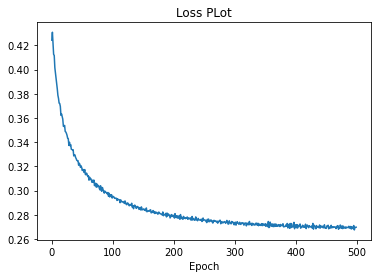

In [0]:
plt.plot(hist)
plt.title('Loss PLot')
plt.xlabel('Epoch')
plt.show()

# 3. K-nearest neighbor

In [0]:
def euclidean_distance(a,b):
    a = np.array(a,dtype= float)
    b = np.array(b,dtype= float)
    return np.sqrt(np.power(a-b,2).sum())

In [0]:
def get_disMat(X_train,X_test):
    rows = len(X_test)
    cols = len(X_train)
    disMat = np.zeros(shape=(rows,cols))

    for row in tqdm(range(rows)):
        for col in range(cols):
            disMat[row][col] = euclidean_distance(X_test[row],X_train[col])
    
    return disMat

In [0]:
def Knn(disMat,y_train,k):
    
    Predictions = []
    y_train = pd.Series(y_train.reshape(len(y_train,))) #convert to pandas series
    for dist in disMat:
        indices = np.argpartition(-dist, -k)[-k:] #get indices of k nearest neighbors        
        p = y_train[indices].value_counts().idxmax() #get label of winner class from majority voting 
        Predictions.append(p)
    
    return np.array(Predictions)

In [0]:
disMat = get_disMat(X_train,X_test).reshape(5724,1)
np.save('disMat',disMat)

In [0]:
disMat = np.load('disMat.npy')

#### K=1

In [0]:
hist = []
knn_pred = Knn(disMat,y_train,1)
acc1 = model_evaluation(knn_pred,y_test)
hist.append(acc1)

CLASSIFIER   |    GOLD LABELS   |
OUTPUT       |    pos   |  neg  |
         pos |   2092   |  1156 |
         neg |   635   |  1841 |
------------------------------------

Model Accuracy :  73.096 %
Precision :  0.644
Recall    :  0.767
F1 score  :  0.7


#### K = 3

In [0]:
knn_pred = Knn(disMat,y_train,3)
acc3 = model_evaluation(knn_pred,y_test)
hist.append(acc3)

CLASSIFIER   |    GOLD LABELS   |
OUTPUT       |    pos   |  neg  |
         pos |   2243   |  1192 |
         neg |   484   |  1805 |
------------------------------------

Model Accuracy :  78.372 %
Precision :  0.653
Recall    :  0.823
F1 score  :  0.728


#### k = 5

In [0]:
knn_pred = Knn(disMat,y_train,5)
acc5 = model_evaluation(knn_pred,y_test)
hist.append(acc5)

CLASSIFIER   |    GOLD LABELS   |
OUTPUT       |    pos   |  neg  |
         pos |   2300   |  1249 |
         neg |   427   |  1748 |
------------------------------------

Model Accuracy :  80.363 %
Precision :  0.648
Recall    :  0.843
F1 score  :  0.733


#### k = 7

In [0]:
knn_pred = Knn(disMat,y_train,7)
acc7 = model_evaluation(knn_pred,y_test)
hist.append(acc7)

CLASSIFIER   |    GOLD LABELS   |
OUTPUT       |    pos   |  neg  |
         pos |   2318   |  1273 |
         neg |   409   |  1724 |
------------------------------------

Model Accuracy :  80.992 %
Precision :  0.646
Recall    :  0.85
F1 score  :  0.734


#### k = 9

In [0]:
knn_pred = Knn(disMat,y_train,9)
acc9 = model_evaluation(knn_pred,y_test)
hist.append(acc9)

CLASSIFIER   |    GOLD LABELS   |
OUTPUT       |    pos   |  neg  |
         pos |   2337   |  1293 |
         neg |   390   |  1704 |
------------------------------------

Model Accuracy :  81.656 %
Precision :  0.644
Recall    :  0.857
F1 score  :  0.735


#### 3.1 Knn Summary

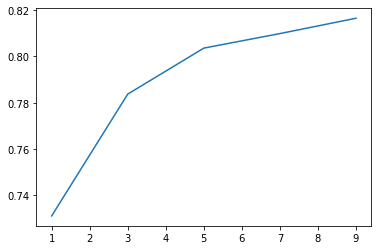

In [0]:
plt.plot([1,3,5,7,9],hist)
plt.show()

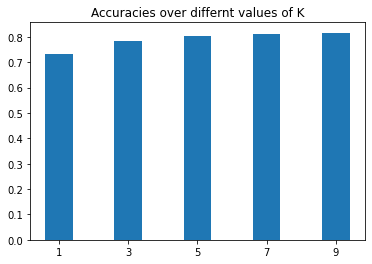

In [0]:
x = [1,3,5,7,9]
plt.bar(x,hist)
plt.xticks(x)
plt.title('Accuracies over differnt values of K')
plt.show()

|  K |Accuracy|Precision|Recall|F1 score|
|---|---|---|---|---|
| 1  |0.730|0.644|0.767|0.700|
| 3  |0.784|0.653|0.823|0.728|
| 5  |0.804|0.648|0.843|0.733|
| 7  |0.809|0.646|0.850|0.734|
| 9  |0.816|0.644|0.857|0.735|


# 4. Perceptron

In [0]:
y_train2 = y_train
y_train2[y_train2==0] = -1

y_test2 = y_test
y_test2[y_test2==0] = -1

In [0]:
class Perceptron():
    def __init__(self,epochs,lr):
        self.epochs = epochs
        self.lr = lr
                
    def predict(self,X):
        predictions = np.zeros(shape = (len(X),1))
        for i in range(len(X)):
            x = np.insert(X[i], 0, 1)
            z = np.dot(self.weights.T,x)
            if z > 0 :
                predictions[i] = 1
            else:
                predictions[i] = -1
        return predictions
    
    def fit(self,X,y):
        self.weights = np.zeros(X.shape[1]+1)
        for epoch in tqdm(range(self.epochs)):    
            m = 0
            for i in range(len(X)):
                x = np.insert(X[i], 0, 1)
                if np.dot(self.weights.T,x) * y_train2[i] <= 0:
                    self.weights = self.weights + self.lr* y[i] * x
                    m = m + 1
            if m == 0:
                break  
        return


In [0]:
jarvis = Perceptron(epochs=5,lr=0.01)
jarvis.fit(X_train,y_train2)
perceptron_pred = jarvis.predict(X_test)
acc = model_evaluation(perceptron_pred,y_test2,'perceptron')


CLASSIFIER   |    GOLD LABELS   |
OUTPUT       |    pos   |  neg  |
         pos |   2659   |  2628 |
         neg |   68   |  369 |
------------------------------------

Model Accuracy :  92.907 %
Precision :  0.503
Recall    :  0.975
F1 score  :  0.664


# 5. Comparision of models


| Model               |Accuracy|Precision|Recall|F1 score|
|-------              |---   |---|---|---|
| Logistic Regression | 0.655 | 0.735 | 0.688 | 0.711 |
| KNN                 | 0.816| 0.644 | 0.857| 0.735 |
| Perceptron          | 0.929 | 0.503 | 0.975 | 0.664 |



**Precision**  
Precision is the ratio of system generated results that correctly predicted positive observations to total predicted positive observations, both correct and incorrect. Implying, how many of headlines labelled by the system as sarcastic are actually sarcastic. High precision indicates low false positive rate. Logistic Regression looks best if this metric is prioritized. 

**Recall**   
Recall is the ratio of system generated results that correctly predicted positive observations to all observations in the actual sarcastic class. Implying, of all the headlines that are sarcastic, how many of those did the algorithm correctly classifies as sarcastic. Recall highlights the sensitivity of the algorithm high recall relates to a low false negative rate. Perceptron is giving best results relatively according to this metric as well. 

**Accuracy**   
Accuracy is a good measure for symmetric datasets and is ratio of the correctly predicted classifications (whether sarcastic or not) to the total Test Dataset. Implying how many sarcastic headlines the system correctly classified out of all the headlines. Perceptron is relatively better according to this metric.    

**F1 value**   
The F1 Score works best for uneven class distribution and is the weighted average of Precision and Recall. higher F1 score means that there are low false positives and low false negatives. KNN also looks best according to this parameter.   

However, Out of all algorithms, it is difficult to decide on the best algorithm using only one metric.It can be chosen based on requirements and expectations from the project.